# Assignment #6: Dependency parsing
Author: Pierre Nugues

## Objectives

This assignment is inspired by the CoNLL 2018 shared task of the conference on computational natural language learning on dependency parsing, http://universaldependencies.org/conll18/. It is a follower of <a href="http://ilk.uvt.nl/conll/">CONLL-X</a>, which was the first large-scale evaluation of dependency parsers.
            
In this session, you will implement a dependency parser for Swedish and, optionally, another language that you will choose.

The objectives of this assignment are to:
* Know what a dependency graph is
* Understand the principles of a transition-based parser
* Extend the parser with a guiding predicate that parses an annotated dependency graph
* Extract features to learn parsing actions from an annotated corpus
* Write a short report on your results

## Organization and location

You can work alone or collaborate with another student.
Each group will have to:
* Write a program that parses a sentence when the dependency graph is known
* Extract features from the parsing actions.
* Train a classifier
* Apply it on a test corpus
* Evaluate the results

## Corpora

As corpora, you will use the Universal Dependencies: https://universaldependencies.org/. The corpora are the same that you used in the 5th assignment, but you will use the test set in addition to the training set. 
1. You will train your parser on training part of the Swedish _Talbanken_ corpus and you will evaluate it on the test set. 
2. Optionally, you will repeat the experiment with another language. 
3. You will comment your results in the report. 

You will load the corpora as in the 5th assignment and the next cells are just copies from this assignment.

### Corpus location

Here are the corpus locations you will use. You may have to adjust `ud_path`.

In [1]:
import os
import copy
ud_path = 'corpus/ud-treebanks-v2.6/'

In [2]:
path_sv_train = ud_path + 'UD_Swedish-Talbanken/sv_talbanken-ud-train.conllu'
path_sv_test = ud_path + 'UD_Swedish-Talbanken/sv_talbanken-ud-test.conllu'
path_eng_train = ud_path + 'UD_English-EWT/en_ewt-ud-train.conllu' 
path_eng_test = ud_path + 'UD_English-EWT/en_ewt-ud-test.conllu'

The column names of the CoNLL-U corpora

In [3]:
column_names_u = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC']

#### Functions to read the CoNLL-U files

In [4]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file, encoding='utf-8').read().strip()
    sentences = f.split('\n\n')
    return sentences

In [5]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    root_values = ['0', 'root', 'root', 'root', 'root', 'root', '0', 'root', 'root', 'root']
    start = [dict(zip(column_names, root_values))]
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split('\t'))) for row in rows if row[0] != '#']
        sentence = start + sentence
        new_sentences.append(sentence)
    return new_sentences

#### Reading the corpus

We load the Swedish _Talbanken_ corpus.

In [6]:
sentences = read_sentences(path_sv_train)
formatted_corpus_train = split_rows(sentences, column_names_u)

In [7]:
len(formatted_corpus_train)

4303

The parsed sentence: _Individuell beskattning av arbetsinkomster_

#### Removing indices that are not integers

To ease the processing of some corpora, we remove the indices which are not integers. We do this because `ID` is not necessarily a number.

In [8]:
def clean_indicies(formatted_corpus):
    formatted_corpus_clean = []
    for sentence in formatted_corpus:
        formatted_corpus_clean.append([word for word in sentence if word['ID'].isdigit()])
    return formatted_corpus_clean          

In [9]:
formatted_corpus_train_clean = clean_indicies(formatted_corpus_train)
formatted_corpus_train_clean[0]

[{'ID': '0',
  'FORM': 'root',
  'LEMMA': 'root',
  'UPOS': 'root',
  'XPOS': 'root',
  'FEATS': 'root',
  'HEAD': '0',
  'DEPREL': 'root',
  'DEPS': 'root',
  'MISC': 'root'},
 {'ID': '1',
  'FORM': 'Individuell',
  'LEMMA': 'individuell',
  'UPOS': 'ADJ',
  'XPOS': 'JJ|POS|UTR|SIN|IND|NOM',
  'FEATS': 'Case=Nom|Definite=Ind|Degree=Pos|Gender=Com|Number=Sing',
  'HEAD': '2',
  'DEPREL': 'amod',
  'DEPS': '2:amod',
  'MISC': '_'},
 {'ID': '2',
  'FORM': 'beskattning',
  'LEMMA': 'beskattning',
  'UPOS': 'NOUN',
  'XPOS': 'NN|UTR|SIN|IND|NOM',
  'FEATS': 'Case=Nom|Definite=Ind|Gender=Com|Number=Sing',
  'HEAD': '0',
  'DEPREL': 'root',
  'DEPS': '0:root',
  'MISC': '_'},
 {'ID': '3',
  'FORM': 'av',
  'LEMMA': 'av',
  'UPOS': 'ADP',
  'XPOS': 'PP',
  'FEATS': '_',
  'HEAD': '4',
  'DEPREL': 'case',
  'DEPS': '4:case',
  'MISC': '_'},
 {'ID': '4',
  'FORM': 'arbetsinkomster',
  'LEMMA': 'arbetsinkomst',
  'UPOS': 'NOUN',
  'XPOS': 'NN|UTR|PLU|IND|NOM',
  'FEATS': 'Case=Nom|Definite=Ind|G

## Transition parser

For each sentence with a projective dependency graph, there is an action sequence that enables the transition parser
to generate this graph. Gold standard parsing corresponds to the sequence of parsing actions, left-arc (<tt>la</tt>), right-arc (<tt>ra</tt>), shift (<tt>sh</tt>), and reduce (<tt>re</tt>) that produces the manually-obtained, gold standard, graph.

### The transitions

Here are implementations of the parsing transitions. Read them and be sure you understand them.

In [10]:
def shift(stack, queue, graph):
    """
    Shift the first word in the queue onto the stack
    :param stack:
    :param queue:
    :param graph:
    :return:
    """
    stack = [queue[0]] + stack
    queue = queue[1:]
    return stack, queue, graph


def reduce(stack, queue, graph):
    """
    Remove the first item from the stack
    :param stack:
    :param queue:
    :param graph:
    :return:
    """
    return stack[1:], queue, graph


def right_arc(stack, queue, graph, deprel=False):
    """
    Creates an arc from the top of the stack to the first in the queue
    and shifts
    The deprel argument is either read from the manually-annotated corpus
    (deprel=False) or assigned by the parser. In this case, the deprel
    argument has a value
    :param stack:
    :param queue:
    :param graph:
    :param deprel: either read from the manually-annotated corpus (value false)
    or assigned by the parser
    :return:
    """
    graph['heads'][queue[0]['ID']] = stack[0]['ID']
    if deprel:
        graph['deprels'][queue[0]['ID']] = deprel
    else:
        graph['deprels'][queue[0]['ID']] = queue[0]['DEPREL']
    # If we create an arc from the 'root', we introduce a statement to pop it to avoid multiple roots
    if stack[0]['ID'] == '0':
        stack = stack[1:]
    return shift(stack, queue, graph)


def left_arc(stack, queue, graph, deprel=False):
    """
    Creates an arc from the first in the queue to the top of the stack
    and reduces it.
    The deprel argument is either read from the manually-annotated corpus
    (deprel=False) or assigned by the parser. In this case, the deprel
    argument has a value
    :param stack:
    :param queue:
    :param graph:
    :param deprel: either read from the manually-annotated corpus (value false)
    or assigned by the parser
    :return:
    """
    graph['heads'][stack[0]['ID']] = queue[0]['ID']
    if deprel:
        graph['deprels'][stack[0]['ID']] = deprel
    else:
        graph['deprels'][stack[0]['ID']] = stack[0]['DEPREL']        
    return reduce(stack, queue, graph)

### Constrains on the transitions

We add a few constraints before we carry out the transitions. Given a manually-annotated dependency graph, look at the conditions (`can_...()` functions) on the stack and the current input list -- the queue -- to execute left-arc, right-arc, shift, or reduce.

In [11]:
def can_reduce(stack, graph):
    """
    Checks that the top of the stack has a head
    :param stack:
    :param graph:
    :return:
    """
    if not stack:
        return False
    if stack[0]['ID'] in graph['heads']:
        return True
    else:
        return False

    
def can_leftarc(stack, graph):
    """
    Checks that the top of the has no head
    :param stack:
    :param graph:
    :return:
    """
    if not stack:
        return False
    if stack[0]['ID'] in graph['heads']:
        return False
    else:
        return True


def can_rightarc(stack):
    """
    Simply checks there is a stack
    :param stack:
    :return:
    """
    if not stack:
        return False
    else:
        return True
    
def can_assign_root(graph):
    return not exists_root(graph);

### Finding the transitions from a manually-parsed sentence

Using an annotated corpus, we can derive the action sequences producing the manually-parsed sentences (provided that they are projective). We use an oracle for this as explained during the lectures.

In [12]:
def oracle(stack, queue, graph):
    """
    Gold standard parsing
    Produces a sequence of transitions from a manually-annotated corpus:
    sh, re, ra.deprel, la.deprel
    :param stack: The stack
    :param queue: The input list
    :param graph: The set of relations already parsed
    :return: the transition and the grammatical function (deprel) in the
    form of transition.deprel
    """
    # Right arc
    if stack and stack[0]['ID'] == queue[0]['HEAD']:
        # print('ra', queue[0]['DEPREL'], stack[0]['UPOS'], queue[0]['UPOS'])
        deprel = '.' + queue[0]['DEPREL']
        stack, queue, graph = right_arc(stack, queue, graph)
        return stack, queue, graph, 'ra' + deprel
    # Left arc
    if stack and queue[0]['ID'] == stack[0]['HEAD']:
        # print('la', stack[0]['DEPREL'], stack[0]['UPOS'], queue[0]['UPOS'])
        deprel = '.' + stack[0]['DEPREL']
        stack, queue, graph = left_arc(stack, queue, graph)
        return stack, queue, graph, 'la' + deprel
    # Reduce
    if stack and can_reduce(stack, graph):
        for word in stack:
            if (word['ID'] == queue[0]['HEAD'] or
                    word['HEAD'] == queue[0]['ID']):
                # print('re', stack[0]['UPOS'], queue[0]['UPOS'])
                stack, queue, graph = reduce(stack, queue, graph)
                return stack, queue, graph, 're'
    # Shift
    # print('sh', [], queue[0]['UPOS'])
    stack, queue, graph = shift(stack, queue, graph)
    return stack, queue, graph, 'sh'

### Dealing with nonprojective graphs

Oracle parsing produces a sequence of transitions if the graph is projective and well-formed. If not, we will have headless words in the stack. Parsing normally terminates when the queue is empty. We also empty the stack to be sure that all the words have a head. We attach headless words to the root word of the sentence.

In [13]:
def exists_root(graph):
    for (x, y)  in graph['heads'].items():
        if y == '0' and x != '0':
            return x
    return False

In [14]:
def empty_stack(stack, graph):
    """
    Pops the items in the stack. If they have no head, they are assigned
    a ROOT head
    :param stack:
    :param graph:
    :return:
    """
    idx_root = exists_root(graph)
    # There is already a root
    if idx_root:
        for word in stack:
            if word['ID'] not in graph['heads']:
                graph['heads'][word['ID']] = idx_root
                graph['deprels'][word['ID']] = 'dep'
    else:
        # There is no root. We assign the root to the first headless word.
        for word in stack:
            if word['ID'] not in graph['heads']:
                if idx_root:
                    graph['heads'][word['ID']] = idx_root
                    graph['deprels'][word['ID']] = 'dep'
                else:
                    graph['heads'][word['ID']] = '0'
                    graph['deprels'][word['ID']] = 'root'
                    idx_root = word['ID']
    stack = []
    return stack, graph

### Checking if two graphs are equal

The `equal_graphs()` utility checks if the graph obtained from a sequence of transitions is equal to the annotated graph. It is normally the case, except with nonprojective graphs.

In [15]:
def equal_graphs(sentence, graph, verbose=False):
    """
    Checks that the graph corresponds to the gold standard annotation of a sentence
    :param sentence:
    :param graph:
    :return:
    """
    equal = True
    for word in sentence:
        if word['ID'] in graph['heads'] and word['HEAD'] == graph['heads'][word['ID']]:
            pass
        else:
            equal = False
            if verbose:
                print(word, flush=True)
    return equal

In [16]:
def equal_graphs_2(sentence, graph, cond_deprel, verbose):
    """
    Checks that the graph corresponds to the gold standard annotation of a sentence
    :param sentence:
    :param graph:
    :return:
    """
    equal = True
    for word in sentence:
        if word['ID'] in graph['heads']:
            if word['HEAD'] == graph['heads'][word['ID']]:
                pass
            else:
                if cond_deprel:
                    equal = not (graph['deprels'][word['ID']] == 'dep')
                else:
                    word['Error'] = 'Wrong head in graph'
                    equal = False
        else:
            word['Error'] = 'Missing ID in graph'
            equal = False
            if verbose:
                print(word, flush=True)
    return equal

In [17]:
#sentence = formatted_corpus_test_clean[0]
#sentence[1]['HEAD'] = '5'
#graph = {'heads' : {'0' : '0', '2' : '5', '2' : '3', '3' : '7', '4' : '7', '5' : '7', '6' : '7', '7' : '0', '8' : '7', '9' : '7', '10' : '11', '11' : '7', '12' : '7', '13' : '7', '14' : '7', '15' : '7'}}
#graph_collection_errors([sentence], [graph])


In [18]:
def graph_collection_errors(sentences, graphs, ret_smalest=True, cond_deprel=False, verbose=False):
    sentences = copy.deepcopy(sentences)
    smallest = 100;
    error_graphs = []
    
    for i, sentence in enumerate(sentences):
        if not equal_graphs_2(sentence, graphs[i], cond_deprel, verbose):
            if not ret_smalest:
                error_graphs.append(sentence);
            elif len(sentence) < smallest: 
                smallest = len(sentence)
                error_graphs = sentence
    return error_graphs

### Parsing an annotated corpus with an oracle

You will now run the code below. With it, you will produce a sequence of transitions for each sentence. If the graph is projective, applying the sequence to the sentence will recreate the gold-standard annotation.

For this experiment:
1. Understand from the slides used during the lecture how the oracle carries out a gold standard parsing. 
2. The parser can only deal with projective sentences. In the case of a nonprojective one, the parsed graph and the manually-annotated sentence are not equal. Examine one nonprojective sentence (just set `verbose`to `True` in the code below) and explain why it is not projective. Take a short one (the shortest). You will **describe** this in the report.

In [19]:
def init_config(sentence):
    stack = []
    queue = list(sentence)
    graph = {}
    graph['heads'] = {}
    graph['heads']['0'] = '0'
    graph['deprels'] = {}
    graph['deprels']['0'] = 'ROOT'
    return stack, queue, graph

In [20]:
verbose = True
projectivization = False

transition_corpus = []
graph_corpus = []

small = 10000
sent = {}
gr = {}
count = 0

for sent_cnt, sentence in enumerate(formatted_corpus_train_clean):
    #print(sentence)
    stack, queue, graph = init_config(sentence)
    transition_sent = []
    while queue:
        stack, queue, graph, trans = oracle(stack, queue, graph)
        transition_sent.append(trans)
    stack, graph = empty_stack(stack, graph)
    transition_corpus.append(transition_sent)
    graph_corpus.append(graph)

    if verbose:
        if not equal_graphs(sentence, graph):
            length = len(sentence)
            
            if(length < small):
                small = length
                sent = sentence
                gr = graph
                count += 1
                
            print('Annotation and gold-standard parsing not equal')
            print('Sentence:', sentence)
            print('Gold-standard graph', graph)
    # Poorman's projectivization to have well-formed graphs.
    # We just just assign the same heads as what gold standard parsing did
    # This guarantee a projective sentence
    if projectivization:
        for word in sentence:
            word['HEAD'] = graph['heads'][word['ID']]
print('\nProcessed ' + str(sent_cnt) + ' sentences')

Annotation and gold-standard parsing not equal
Sentence: [{'ID': '0', 'FORM': 'root', 'LEMMA': 'root', 'UPOS': 'root', 'XPOS': 'root', 'FEATS': 'root', 'HEAD': '0', 'DEPREL': 'root', 'DEPS': 'root', 'MISC': 'root'}, {'ID': '1', 'FORM': 'Kommunalt', 'LEMMA': 'kommunal', 'UPOS': 'ADJ', 'XPOS': 'JJ|POS|NEU|SIN|IND|NOM', 'FEATS': 'Case=Nom|Definite=Ind|Degree=Pos|Gender=Neut|Number=Sing', 'HEAD': '2', 'DEPREL': 'amod', 'DEPS': '2:amod', 'MISC': '_'}, {'ID': '2', 'FORM': 'grundavdrag', 'LEMMA': 'grundavdrag', 'UPOS': 'NOUN', 'XPOS': 'NN|NEU|SIN|IND|NOM', 'FEATS': 'Case=Nom|Definite=Ind|Gender=Neut|Number=Sing', 'HEAD': '4', 'DEPREL': 'nsubj:pass', 'DEPS': '4:nsubj:pass', 'MISC': '_'}, {'ID': '3', 'FORM': 'kan', 'LEMMA': 'kunna', 'UPOS': 'AUX', 'XPOS': 'VB|PRS|AKT', 'FEATS': 'Mood=Ind|Tense=Pres|VerbForm=Fin|Voice=Act', 'HEAD': '4', 'DEPREL': 'aux', 'DEPS': '4:aux', 'MISC': '_'}, {'ID': '4', 'FORM': 'avräknas', 'LEMMA': 'avräkna', 'UPOS': 'VERB', 'XPOS': 'VB|PRS|SFO', 'FEATS': 'Mood=Ind|Tens

Annotation and gold-standard parsing not equal
Sentence: [{'ID': '0', 'FORM': 'root', 'LEMMA': 'root', 'UPOS': 'root', 'XPOS': 'root', 'FEATS': 'root', 'HEAD': '0', 'DEPREL': 'root', 'DEPS': 'root', 'MISC': 'root'}, {'ID': '1', 'FORM': '-', 'LEMMA': '-', 'UPOS': 'PUNCT', 'XPOS': 'MID', 'FEATS': '_', 'HEAD': '7', 'DEPREL': 'punct', 'DEPS': '7:punct', 'MISC': '_'}, {'ID': '2', 'FORM': 'De', 'LEMMA': 'en', 'UPOS': 'DET', 'XPOS': 'DT|UTR/NEU|PLU|DEF', 'FEATS': 'Definite=Def|Number=Plur|PronType=Art', 'HEAD': '4', 'DEPREL': 'det', 'DEPS': '4:det', 'MISC': '_'}, {'ID': '3', 'FORM': 'här', 'LEMMA': 'här', 'UPOS': 'ADV', 'XPOS': 'AB', 'FEATS': '_', 'HEAD': '2', 'DEPREL': 'fixed', 'DEPS': '2:fixed', 'MISC': '_'}, {'ID': '4', 'FORM': 'områdena', 'LEMMA': 'område', 'UPOS': 'NOUN', 'XPOS': 'NN|NEU|PLU|DEF|NOM', 'FEATS': 'Case=Nom|Definite=Def|Gender=Neut|Number=Plur', 'HEAD': '7', 'DEPREL': 'obl', 'DEPS': '7:obl:om', 'MISC': '_'}, {'ID': '5', 'FORM': 'vill', 'LEMMA': 'vilja', 'UPOS': 'AUX', 'XPOS'

Gold-standard graph {'heads': {'0': '0', '1': '2', '3': '2', '4': '2', '5': '4', '6': '4', '7': '2', '2': '8', '8': '0', '9': '10', '10': '8', '12': '13', '14': '13', '16': '17', '15': '17', '17': '13', '18': '8', '13': '8', '11': '8'}, 'deprels': {'0': 'ROOT', '1': 'det', '3': 'punct', '4': 'parataxis', '5': 'obj', '6': 'punct', '7': 'punct', '2': 'nsubj', '8': 'root', '9': 'amod', '10': 'obj', '12': 'expl', '14': 'nsubj', '16': 'advmod', '15': 'mark', '17': 'advcl', '18': 'dep', '13': 'dep', '11': 'dep'}}
Annotation and gold-standard parsing not equal
Sentence: [{'ID': '0', 'FORM': 'root', 'LEMMA': 'root', 'UPOS': 'root', 'XPOS': 'root', 'FEATS': 'root', 'HEAD': '0', 'DEPREL': 'root', 'DEPS': 'root', 'MISC': 'root'}, {'ID': '1', 'FORM': 'Detta', 'LEMMA': 'denna', 'UPOS': 'PRON', 'XPOS': 'PN|NEU|SIN|DEF|SUB/OBJ', 'FEATS': 'Definite=Def|Gender=Neut|Number=Sing|PronType=Dem', 'HEAD': '4', 'DEPREL': 'nsubj', 'DEPS': '4:nsubj', 'MISC': '_'}, {'ID': '2', 'FORM': 'är', 'LEMMA': 'vara', 'UPO

### Checking gold-standard parsing

Apply manually the transition sequence you obtained to the first sentence and check that it parses it correctly. You will draw a stack and a queue with **seven steps** and you will describe this in your report

In [21]:
def getText(sentence):
    text = ""
    
    for word in sentence:
        text += word['FORM'] + " "
        
    return text       

## Training a classifier

We can now train a classifier to predict an action from a current parsing context. To be able to predict the next action from a given parsing state, gold standard parsing must also extract feature vectors at each step of the parsing procedure. The simplest parsing context corresponds to words' part of speech on the top of the stack and head of the input list (the queue).
    
Once the data collected, the training procedure will produce a 4-class classifier that you will embed in
Nivre's parser to choose the next action. During parsing, Nivre's parser will call the classifier to choose
the next action in the set {<tt>la</tt>, <tt>ra</tt>, <tt>sh</tt>, <tt>re</tt>} using the current context.

You will use two feature sets to build your models:
* The top of the stack and the first word of the input list (word forms and parts of speech);
* The two first words and POS on the top of the stack and the two first words and POS of the input list;
* You will also add constraints to actions. You will encode these constraints as Boolean features.

### Parsing the grammatical functions

Using the actions in the set {<tt>la</tt>, <tt>ra</tt>, <tt>sh</tt>, <tt>re</tt>} produces an unlabelled
graph. It is easy to extend the parser so that it can label the graph with grammatical functions. In this
case, we must complement the actions <tt>la</tt>
and <tt>ra</tt> with their function using this notation for example:<tt>la.mod</tt>, <tt>la.case</tt>, <tt>ra.nmod</tt>, etc. where the prefix is the action and the suffix is the function.

### Extracting features 

The final goal is to parse the Swedish corpus and produce a labelled dependency graph. 

You will consider two feature sets and you will train the corresponding logistic regression models using scikit-learn:
1. The first set will use the word and the part of speech extracted from the first element in the stack and the first in the queue,
2. the second one will use two elements from the stack and two from the input list.

These sets will include two additional Boolean parameters, "can do left arc" and "can do reduce", which will model constraints on the parser's actions. In total, the feature sets will then have six, respectively ten parameters.

This means that the purpose of this assignment is to generate two scikit-learn models for the labelled graphs. We use the depth parameter for this: The depth of the stack and the queue, either 1 or 2. Start with 1.

In [22]:
import regex as re
import numpy as np


def symbols_to_num(symbols):
    idx = {}
    unique_labels = 0
    
    for symbol in symbols:
        if symbol not in idx:
            idx[symbol] = unique_labels
            unique_labels += 1
            
    return idx, unique_labels  

def one_hot_line(symbol, dimension, mapper):
    encoding = np.zeros((1, dimension))
    
    if symbol in mapper:
        encoding[0, mapper[symbol]] = 1
    
    return  encoding[0]
    
def one_hot_set(symbols, dimension, mapper):
    encoding = np.zeros((len(symbols), dimension))
    
    for i, symbol in enumerate(symbols):
        encoding[i] = one_hot_line(symbol, dimension, mapper)
    
    return encoding

def one_hot_set_all(symbols_list, dimension = 2, mapper = 'boolean'):
    one_hot_matrixes = []
    
    for symbols in symbols_list:
        one_hot_matrix = 0
        
        if mapper == 'boolean':
            one_hot_matrix = boolean_one_hot_set(symbols)
        else: 
            one_hot_matrix = one_hot_set(symbols, dimension, mapper)
            
        one_hot_matrixes.append(one_hot_matrix)
        
    return one_hot_matrixes

def to_one_hot(mapper, dimension, add_missing=True):   
    to_one_hot = {}
    
    if add_missing: 
        dimension += 1
        to_one_hot['ZERO'] = np.zeros((1, dimension))[0]
    
    for word in mapper:
        if word not in to_one_hot:
            to_one_hot[word] = one_hot_line(word, dimension, mapper)

    return to_one_hot, dimension

def boolean_one_hot_set(values):
    one_hot = np.zeros((len(values), 2))
    
    for i, value in enumerate(values):
        if value:
            one_hot[i, 0] = 1
        else:
            one_hot[i, 1] = 1
    
    return one_hot

In [23]:
def extract_file(path, split = False):
    file_text = open(path, encoding='utf-8').read().strip()
    
    if split:
        return re.split(split, file_text) 
    return file_text

In [24]:
pos_codes_path = 'pos_codes.txt'
pos_codes = extract_file(pos_codes_path, '\n')

pos_mapper, pos_column_length = symbols_to_num(pos_codes)
pos_one_hot, pos_column_length = to_one_hot(pos_mapper, pos_column_length, add_missing = False)

In [25]:
swe_embeddings_path = 'swectors-300dim.txt' 
whitespace = "\p{IsWhite_Space}"

def get_embeddings():
    word_data_header = extract_file(swe_embeddings_path, split = '\n')
    
    header = word_data_header[0]
    word_data = word_data_header[1:]
    
    return word_data, re.split(whitespace, header)   

def process(embedding_data_text, length, dimension):
    embeddings = np.zeros((length, dimension))
    word_to_idx = {}
    word_to_idx['ZERO'] = 0
    
    for line_nbr, word_data in enumerate(embedding_data_text):
        line_nbr += 1
        tokens = re.split(whitespace, word_data)
        
        word = tokens[0]
        word_to_idx[word] = line_nbr
        
        token_embedding_values = tokens[1:]
        data = list(map(lambda data_point: float(data_point), token_embedding_values))
        
        embeddings[line_nbr] = data
    
    return embeddings, word_to_idx

def lines_to_idx(lines, shift=0):
    line_idx = {}
    
    for i, line in enumerate(lines):
        line_idx[line] = i + shift
    
    return line_idx

In [26]:
embeddings, header = get_embeddings()
nbr_word_embeddings = int(header[0]) + 1
dimension_embeddings = int(header[1])

In [27]:
pos_idx = lines_to_idx(pos_codes)
pos_idx['missing'] = 'nil'

In [28]:
deprels_codes_path = 'deprel_codes.txt'
deprels_codes = extract_file(deprels_codes_path, '\n')
deprel_idx = lines_to_idx(deprels_codes, shift = 1)
deprel_idx['ZERO'] = 0

In [29]:
embeddings, word_to_idx = process(embeddings, nbr_word_embeddings, dimension_embeddings)


In [30]:
print(len(embeddings))
nbr_word_embeddings

192251


192251

In [31]:
word_to_idx['i']

1

In [32]:

def get_or_zero(dic, element, to_missing='ZERO'):
    if element in dic:
        return dic[element]
    else:
        return dic[to_missing]

You will need the `queue_stack()` function.

In [33]:
def init_list(value, depth):
    return [value] * depth

In [34]:
def init_dict(tags, value, depth):
    new_dic = {}
    
    for tag in tags:
        new_dic[tag] = init_list(value, depth)
        
    return new_dic

In [35]:
def queue_stack(queue_or_stack, graph, depth, pos=True, lex=True):
    tags = ['pos', 'form']
    features = init_dict(tags, 0, depth)
    
    if queue_or_stack:
        for i, word in list(enumerate(queue_or_stack))[:depth]:
            element = queue_or_stack[i]
            
            features['pos'][i] = get_or_zero(pos_idx, element['UPOS'], pos_idx['missing'])
            features['form'][i] = get_or_zero(word_to_idx, element['FORM'].lower())
    return features

In [36]:
def children(graph, item_id):
    children_graph = dict(filter(lambda entry: entry[1] == item_id, graph.items()))
    children = map(lambda entry: entry, children_graph)
    
    children_sorted = list(sorted(children, key = lambda key: int(key)))

    return children_sorted

In [37]:
def dynamic_extractor(sentence, stack, graph, depth=2, get_children=True):
    far_depth = depth * 4 
    
    if get_children:
        far_depth += depth * 2
    
    tags = ['pos', 'form', 'deprel']
    features = init_dict(tags, 0, far_depth)

    return dynamic_extraction(sentence, stack, graph['heads'], features, depth, get_children) 


In [38]:
def extract_children_left_right(depth, children_ids, sentence, features, start_index, left=True, right=True):
    children = []
    size = len(children_ids)
    
    if left:
        for i in range(depth):
            if i < size:
                child_id = children_ids[i]
                child = sentence[int(child_id)]
                
                children.append(child)
            else:
                break
                
    if right:
        for j in range(depth):
            index = size - (j + 1)
            
            if index >= depth:
                child_id = children_ids[index]
                child = sentence[int(child_id)]
                
                children.append(child)
            else:
                break
    
    for i, child in enumerate(children):
        features['pos'][start_index + i] = get_or_zero(pos_idx, child['UPOS'], pos_idx['missing'])
        features['form'][start_index + i] = get_or_zero(word_to_idx, child['FORM'].lower())
        features['deprel'][start_index + i] = get_or_zero(deprel_idx, child['DEPREL'])

In [39]:
def dynamic_extraction(sentence, stack, heads, features, depth, get_children):
    start_index = 0
    
    if stack:
        for step, element in enumerate(stack[:depth]):
            element_id = element['ID']
            children_ids = children(heads, element_id)
           
            extract_children_left_right(depth, children_ids, sentence, features, start_index)
            start_index += 2 * depth 
            
            size = len(children_ids)
            
            if get_children and size > 0:
                left_child_children_ids = children(heads, children_ids[0]) 
                extract_children_left_right(1, left_child_children_ids, sentence, features, start_index
                    , right = False)
                start_index += 1
                
                if size > 1:
                    last_index = size - 1
                    right_child_children_ids = children(heads, children_ids[last_index]) 
                    extract_children_left_right(1, right_child_children_ids, sentence, features, start_index
                        , left = False)
                    start_index += 1
            
    return features


In [40]:
#formatted_corpus_test_clean[1]

Optionally, you may want to extend the feature vector with words to the left of the top of the stack with the `right_context()` function. If the top of the stack has index $i$, you will extract the words and their parts of speech at index $i + 1$, $i+2$. This will noticeably improve the performance.

In [41]:
def right_context(stack, sentence, depth, pos=True, lex=True):
    features = {'pos' : init_list(0, depth), 'form' : init_list(0, depth)}
    
    if stack:
        fw_id = int(stack[0]['ID']) + 1
        for i, word in list(enumerate(sentence))[fw_id: fw_id + depth]:
            features['pos'][i - fw_id] = get_or_zero(pos_idx, sentence[i]['UPOS'], pos_idx['missing'])
            features['form'][i - fw_id] = get_or_zero(word_to_idx, sentence[i]['FORM'].lower())

    return features

The next function returns the features in a dictionary format compatible with scikit-learn. You have a code example of feature encoding in this format in the chunking program.

In [42]:
def assign_all(target, source, start=0):
    for i, item in enumerate(source):
        target[i + start] = item
        
    return i

In [43]:
#can_assign_root(graph) removed feature

def extract(depth, stack, queue, graph, sentence, shape):
    """
    :param stack:
    :param queue:
    :param graph:
    :param feature_names:
    :param sentence:
    :return:
    """
    X_pos = [0] * shape[0]
    X_form = [0] * shape[1]
    X_deprel = [0] * shape[2]
    X_bool = [0] * shape[3]
    X_pos_index = 0
    X_pos_form = 0
    
    stack_features = queue_stack(stack, graph, depth)
    X_pos_index += assign_all(X_pos, stack_features['pos'])
    X_pos_form += assign_all(X_form, stack_features['form'])
    
    stack_dynamic = dynamic_extractor(sentence, stack, graph, get_children = True)
    X_pos_index += assign_all(X_pos, stack_dynamic['pos'], start = X_pos_index)
    X_pos_form += assign_all(X_form, stack_dynamic['form'], start = X_pos_form)
    assign_all(X_deprel, stack_dynamic['deprel'])
    
    queue_pos_form = queue_stack(queue, graph, depth)        
    X_pos_index += assign_all(X_pos, queue_pos_form['pos'], start = X_pos_index)
    X_pos_form += assign_all(X_form, queue_pos_form['form'], start = X_pos_form)

    context_pos_form = right_context(stack, sentence, 2)
    X_pos_index += assign_all(X_pos, context_pos_form['pos'], start = X_pos_index)
    X_pos_form += assign_all(X_form, context_pos_form['form'], start = X_pos_form)
    
    X_bool[0] = can_reduce(stack, graph)
    X_bool[1] = can_leftarc(stack, graph)
    
    return X_pos, X_form, X_deprel, X_bool 
   

Now write a loop to parse the annotated corpus using the oracle and collect the features in a matrix ($\mathbf{X}$) and the transitions in a vector ($\mathbf{y}$). 

The first lines of your features for the 4 parameters ($\mathbf{x}$) and labelled actions ($y$) should look like the excerpt below, where the columns correspond to stack0_POS, stack1_POS, stack0_word, stack1_word, queue0_POS, queue1_POS, queue0_word, queue1_word, can-re, can-la, and the transition value (`depth = 2`):
$\mathbf{X} =
\begin{bmatrix}
\text{nil}& \text{nil} &\text{nil} & \text{nil} & \text{ROOT} & \text{ADJ} & \text{ROOT} & \text{Individuell} & \text{False} & \text{False}\\
\text{ROOT} &     \text{nil} &     \text{ROOT} &     \text{nil} &     \text{ADJ} &     \text{NOUN} &     \text{Individuell} &     \text{beskattning} &     \text{True} &     \text{False}\\ 
\text{ADJ} &     \text{ROOT} &     \text{Individuell} &     \text{ROOT} &     \text{NOUN} &     \text{ADP} &     \text{beskattning} &     \text{av} &     \text{False} &     \text{True}\\ 
\text{ROOT} &     \text{nil} &     \text{ROOT} &     \text{nil} &     \text{NOUN} &     \text{ADP} &     \text{beskattning} &     \text{av} &     \text{True} &     \text{False}\\
\text{NOUN} &     \text{ROOT} &     \text{beskattning} &     \text{ROOT} &     \text{ADP} &     \text{NOUN} &     \text{av} &     \text{arbetsinkomster} &     \text{True} &     \text{False}\\
\text{ADP} &     \text{NOUN} &     \text{av} &     \text{beskattning} &     \text{NOUN} &     \text{nil} &     \text{arbetsinkomster} &     \text{nil} &     \text{False} &     \text{True}\\  \text{NOUN} &     \text{ROOT} &     \text{beskattning} &     \text{ROOT} &     \text{NOUN} &     \text{nil} &     \text{arbetsinkomster} &     \text{nil} &     \text{True} &  \text{False}
\end{bmatrix}$
; $\mathbf{y} =
\begin{bmatrix}
\text{sh}\\
\text{sh}\\
\text{la.amod}\\
\text{ra.root}\\
\text{sh}\\
\text{la.case}\\
\text{ra.nmod}
\end{bmatrix}$

You will store your matrix in a Python dictionary and the classes in a list

In [44]:
def generate_feature_list(size_feature_groups):
    feature_list_group = []
    
    for index, amount_of_features in enumerate(size_feature_groups):
        feature_list_group.append([])
        
        for trash in range(amount_of_features):
            feature_list_group[index].append([])
    return feature_list_group

In [45]:
def append_all(l_target, l_source):
    for i, item in enumerate(l_source):
        l_target[i].append(item)

In [46]:
def append_if_known_else(mapper, item, new_item):
    if item in mapper:
        mapper[item].append(new_item)
    else:
        mapper[item] = [new_item]

In [47]:
size_feature_groups = [20, 20, 12, 2]
depth = 3

X_pos, X_form, X_deprel, X_bool = generate_feature_list(size_feature_groups)
y_labels = []

known_features = {}

# Write your code here
for sentence in formatted_corpus_train_clean:  
    stack, queue, graph = init_config(sentence) 

    while queue:
        values = extract(depth, stack, queue, graph, sentence, size_feature_groups)
        append_all(X_pos, values[0])
        append_all(X_form, values[1])
        append_all(X_deprel, values[2])
        append_all(X_bool, values[3])
        
        stack, queue, graph, instruction = oracle(stack, queue, graph)
        y_labels.append(instruction)

In [48]:
def zip_iterating_lists_dic(moving_list, stagnate_list):
    target = {}
    
    for index, moving in enumerate(moving_list):
        word = stagnate_list[index]
        
        for num_id, item in enumerate(moving):
            target['{}{}'.format(word, num_id)] = item
            
    return target

In [49]:
X_train = {}

#one hot
#X_pos_one_hot = one_hot_set_all(X_pos, dimension = pos_column_length, mapper = pos_mapper) 
X_pos = list(map(lambda pos_indexes_row: np.array(pos_indexes_row), X_pos)) 
X_form = list(map(lambda form_indexes_row: np.array(form_indexes_row), X_form))  
X_deprel = list(map(lambda deprel_indexes_row: np.array(deprel_indexes_row), X_deprel))  
X_bool_one_hot = one_hot_set_all(X_bool)
    
features = [X_pos, X_form, X_deprel, X_bool_one_hot]
tags = ['pos', 'form', 'deprel', 'bool']

X_train = zip_iterating_lists_dic(features, tags)

for k, v in X_train.items():
    if k[0:4] == 'form':
        X_train[k] = X_train[k].reshape(-1, 1)
    elif k[0:3] == 'pos':
        X_train[k] = X_train[k].reshape(-1, 1)
    elif k[0:6] == 'deprel':
        X_train[k] = X_train[k].reshape(-1, 1)
    elif k[0:4] == 'bool':
        X_train[k] = X_train[k].reshape(-1, 1, 2)

In [133]:
y_to_idx, y_dimension = symbols_to_num(y_labels)
y_train = one_hot_set(y_labels, y_dimension, y_to_idx)
y_to_one_hot, y_dimension_zero  = to_one_hot(y_to_idx, y_dimension, add_missing = False)

classes = list(y_to_idx.keys())

In [131]:
y_to_one_hot

{'sh': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'la.amod': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'ra.root': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'la.case': array(

In [51]:
print(X_train['deprel7'].shape)
print(X_train['pos0'].shape)
print(X_train['form12'].shape)
print(X_train['bool0'].shape)

(128442, 1)
(128442, 1)
(128442, 1)
(128442, 1, 2)


In [52]:
def construct_input(struc_shape, labels, shapes, dtypes):
    feature_input = {}
    
    for index, row in enumerate(struc_shape):
        for i in range(row):
            key = '{}{}'.format(labels[index], i)
            feature_input[key] = Input(shape = shapes[index], dtype = dtypes[index], name = key)
                
    return feature_input

In [53]:
import regex as re
regex = "[0-9]+"

def construct_embedding(feature_input, embedder):
    embedding_input = feature_input.copy()
    
    for key, value in feature_input.items():
        tag = re.split(regex, key)[0]
        if tag in embedder:
            embedding_input[key] = embedder[tag](value) 
            
    return embedding_input

In [345]:
# Write your code here
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras import metrics 
keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')


#feature_input['pos0'] =  Input(shape = (1, pos_column_length), dtype = 'float32', name = 'pos0')
#feature_input['pos0'] =  Input(shape = (1, ), dtype = 'int32', name = 'pos0')
#feature_input['form0'] =  Input(shape = (1, ), dtype = 'int32', name = 'form0')
#feature_input['bool0'] = Input(shape = (1, 2), dtype = 'float32', name = 'bool1')

shapes = [(1, ), (1, ), (1, ), (1, 2)]
dtypes = ['int64', 'int64', 'int64', 'float64']

feature_input = construct_input(size_feature_groups, tags, shapes, dtypes)


embedding_pos_layer = layers.Embedding(
    nbr_word_embeddings, 
    11, 
    trainable = True,
    mask_zero = False
)

embedding_form_layer = layers.Embedding(
    nbr_word_embeddings, 
    dimension_embeddings, 
    embeddings_initializer = keras.initializers.Constant(embeddings),
    trainable = True,
    mask_zero = False
)

embedding_deprel_layer = layers.Embedding(
    nbr_word_embeddings, 
    15, 
    trainable = True,
    mask_zero = False
)


embedder = {'pos' : embedding_pos_layer, 'form' : embedding_form_layer, 'deprel' : embedding_deprel_layer}
concat_input = construct_embedding(feature_input, embedder)

#concat_input['pos0'] = embedding_pos_layer(feature_input['pos0'])

concat_input_sorted = [value for key, value in sorted(concat_input.items(), key=lambda tupel: tupel[0])]

concatenated_layer = layers.Flatten()(layers.concatenate(concat_input_sorted, axis = -1))

In [55]:
s = "\n"
deprels = list(set(map(lambda x: x[3:],filter(lambda x: '.' in x, y_labels))))

deprels = s.join(deprels)

In [56]:
#with open('deprel_codes.txt', 'w') as f:
    #f.write(deprels)

In [57]:
def format_training_data(validation_split, X_data, Y_data, last=False):
    size = len(Y_data)
    
    validation_index = 0
    validation_start_index = 0
    training_index = 0
    training_start_index = 0
    
    if last:
        validation_start_index = int(size * validation_split)
        validation_index = size
        
        training_index = validation_start_index
    else:
        validation_index = int(size * validation_split)
        
        training_index = size
        training_start_index = validation_index
        
    
    validation_data = {'x' : {}, 'y' : []}
    training_data = {'x' : {}, 'y' : []}
    
    for X_item in X_data.items():
        validation_data['x'][X_item[0]] = X_item[1][validation_start_index:validation_index]
        training_data['x'][X_item[0]] = X_item[1][training_start_index:training_index]
    
    validation_data['y'] = Y_data[validation_start_index:validation_index]
    training_data['y'] = Y_data[training_start_index:training_index]
    
    return validation_data, training_data

In [58]:
validation_data, train_data = format_training_data(0.3, X_train, y_train, last = False)


In [59]:
 k = []

In [60]:


def my_loss_fn(y_true, y_pred):
    
    squared_difference = tf.square(y_true - y_pred)
    return y_true - y_pred

In [62]:
def __init__(self, out_layer, beam=1, name="beam"):
        super().__init__(name=name)
        self.beam = beam
        self.out_layer = out_layer

    def call(self, y_true, y_pred):
        tf.print("hej")
        squared_difference = tf.square(y_true - y_pred)
        tf.print(self.out_layer)
        return tf.reduce_mean(squared_difference, axis=-1)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [445]:
l = 0

In [59]:
optimizer = optimizers.RMSprop(
    centered = False
)

In [ ]:
class beam_search(keras.losses.Loss):
    def __init__(self, out_layer, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor
        self.out_layer = out_layer

    def call(self, y_true, y_pred):
        tf.print(self.out_layer.output)
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred)
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor
    

In [346]:

drop_out_1 = layers.Dropout(0.35)(concatenated_layer)
middle_layer = layers.Dense(200, activation = 'relu')(drop_out_1)

drop_out_2 = layers.Dropout(0.35)(middle_layer)
out_layer = layers.Dense(y_dimension_zero, activation = 'softmax')(drop_out_2)

model = Model(feature_input, out_layer)
Model.compile(model)

train_data_set = tf.data.Dataset.from_tensor_slices((train_data['x'], train_data['y']))
train_data_set = train_data_set.batch(1, drop_remainder = True)

validation_data_set = tf.data.Dataset.from_tensor_slices((validation_data['x'], validation_data['y']))
validation_data_set = validation_data_set.batch(100, drop_remainder = True)

In [416]:
@tf.function
def loss_fn(y_true, y_pred):
    print(y_true)
    squared_difference = tf.square(y_true - y_pred)
    print(tf.square(y_true))
    return tf.reduce_mean(squared_difference, axis=-1)

In [61]:
def data_set(data_x):
    data_set = tf.data.Dataset.from_tensor_slices((data_x))
    data_set = data_set.batch(1, drop_remainder = True)
    
    return data_set

In [62]:
def zip_with(data_1, data_2):
    return zip(data_1, data_2)

In [201]:
def get_highest_until_tuple_handler(tuple_objects, selection_range, tool=1):
    sorted_tuples = sorted(tuple_objects, key=lambda tupel: -tupel[0])
    max_value = sorted_tuples[0][0]
    
    filtred_tuples = [tupel for tupel in sorted_tuples if tupel[0] > max_value - tool]
    
    return filtred_tuples[0:selection_range]

In [172]:
def one_hot_to_label(one_hot_mapper, data):
    label = [x[0] for x in one_hot_mapper.items() if all(data == x[1])][0]
    
    return label

In [466]:
x = 0

In [477]:
import math

class Trainer:
    def __init__(self, tool, depth, classes, size_feature_groups):
        self.tool = tool
        self.depth = depth
        self.classes = classes
        self.size_feature_groups = size_feature_groups
        
    def top_predictions(self, stack, queue, graph, sentence, selection_range):
        next_features = self.extract_features(stack, queue, graph, sentence)
                        
        data = data_set(next_features)
        
        iterator = data.as_numpy_iterator()
        next_batch = next(iterator)
        
        prediction_classes = self.train_classes(next_batch)
        top_predictions = get_highest_until_tuple_handler(prediction_classes, selection_range, self.tool)
        
        return top_predictions
            
    def top_predictions_golden(self, selection_range, next_batch_x, y_label):
        prediction_classes = self.train_classes(next_batch_x)
        global x
        x = next_batch_x
        
        golden_prob = [item[0] for item in prediction_classes if item[1] == y_label][0]
        
        top_predictions = get_highest_until_tuple_handler(prediction_classes, selection_range, self.tool)
                        
        return top_predictions, golden_prob
    
    def train_classes(self, batch):
        predictions = self.predict(batch).numpy()
       
        predictions_classes = list(zip_with(predictions, self.classes))
        
        return predictions_classes
        
    def extract_features(self, stack, queue, graph, sentence):
        features_extracted = extract(self.depth, stack, queue, graph, sentence, self.size_feature_groups)
        pos_features, form_features, deprel_features, boolean_features = features_extracted

        pos = list(map(lambda pos_indexes_row: np.array(pos_indexes_row), pos_features)) 
        form = list(map(lambda form_indexes_row: np.array(form_indexes_row), form_features))  
        deprel = list(map(lambda deprel_indexes_row: np.array(deprel_indexes_row), deprel_features))  
        bool_one_hot = boolean_one_hot_set(boolean_features)

        features = [pos, form, deprel, bool_one_hot]
        tags = ['pos', 'form', 'deprel', 'bool']

        x = zip_iterating_lists_dic(features, tags)

        for k, v in x.items():
            if k[0:4] == 'form':
                x[k] = x[k].reshape(-1, 1)
            elif k[0:3] == 'pos':
                x[k] = x[k].reshape(-1, 1)
            elif k[0:6] == 'deprel':
                x[k] = x[k].reshape(-1, 1)
            elif k[0:4] == 'bool':
                x[k] = x[k].reshape(-1, 1, 2)
                
        return x
            
    @tf.function
    def predict(self, x):
        with tf.GradientTape() as tape:
            logits = model(x, training = False)[0]
              
        return logits
    
    @tf.function 
    def gradient_step(self, golden_sequence_probabilites, all_sequence_probabilites):
        with tf.GradientTape() as tape:
            self.predict(x)
            golden_total_probabilites = sum(golden_sequence_probabilites)
            loss_value = -golden_total_probabilites

            accumelator = 0
            for branch_sequence_probabilites in all_sequence_probabilites:
                accumelator += math.exp(sum(branch_sequence_probabilites))

            loss_value += math.log(accumelator)

        print(loss_value)
        grads = tape.gradient(loss_value, model.trainable_weights)
        print(grads)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        return loss_value

In [320]:
class Branch_Factory:
    
    def update_branch(self, branch, proposed_action, prob_of_action):
        stack, queue, graph = branch.params
        stack, queue, graph, action = self.apply_transition(stack, queue, graph, proposed_action)

        branch.sequence.append(action)
        branch.sequence_probability *= prob_of_action
        branch.params = [stack, queue, graph]
    
    def generate_next_parameters(self, old_branch, proposed_action, prob_of_action):
        stack, queue, graph = old_branch.deep_copy_params()
        stack, queue, graph, action = self.apply_transition(self, stack, queue, graph, proposed_action)
        
        sequence = old_bramch.sequence + [action]
        new_sequence_probability = old_branch.sequence_probability * prob_of_action
        
        params = [stack, queue, graph]
        return params, sequence, new_sequence_probability
    
    def apply_transition(self, stack, queue, graph, trans):
        if stack and trans[:2] == 'ra':
            if trans[3:] == 'root' and exists_root(graph):
                stack, queue, graph = shift(stack, queue, graph)
                return stack, queue, graph, 'sh'
            else:
                stack, queue, graph = right_arc(stack, queue, graph, trans[3:])
                return stack, queue, graph, 'ra'
            
        if stack and can_leftarc(stack, graph) and trans[:2] == 'la':
            if trans[3:] == 'root' and exists_root(graph):
                stack, queue, graph = shift(stack, queue, graph)
                return stack, queue, graph, 'sh'
            else:
                stack, queue, graph = left_arc(stack, queue, graph, trans[3:])
                return stack, queue, graph, 'la'
            
        if stack and can_reduce(stack, graph) and trans == 're':
            stack, queue, graph = reduce(stack, queue, graph)
            return stack, queue, graph, 're'
        
        stack, queue, graph = shift(stack, queue, graph)
        return stack, queue, graph, 'sh'
    

In [321]:
class Branch_Factory_Train(Branch_Factory):
    
    def create_new_branch_from_old(self, old_branch, proposed_action, prob_of_action, golden):
        params, sequence, sequence_probability = self.generate_next_parameters(
            old_branch, 
            proposed_action, 
            prob_of_action
        )
        
        new_sequence_probabilites = copy.copy(old_branch.sequence_probabilites).append(prob_of_action)
                                     
        new_branch = Train_Branch(params, sequence, sequence_probability, new_sequence_probabilites, golden)
        
        return new_branch
    
    def update(self, branch, proposed_action, prob_of_action, golden):
        self.update_branch(branch, proposed_action, prob_of_action)
        
        branch.sequence_probabilites.append(prob_of_action)
        branch.golden = golden

In [322]:
class Branch:   

    def __init__(self, params, sequence, sequence_probability):
        self.params = params
        self.sequence = sequence
        self.sequence_probability = sequence_probability
        
        
    def deep_copy_params():
        stack, queue, graph = self.params
        stack, queue, graph = copy.deepcopy(stack), copy.deepcopy(queue), copy.deepcopy(graph)
        
        return [stack, queue, graph]  

In [331]:
class Train_Branch(Branch):
    
    def __init__(self, params, sequence, sequence_probability, sequence_probabilites, golden):
        super().__init__(params, sequence, sequence_probability) 
        self.sequence_probabilites = sequence_probabilites
        self.golden = golden 
        
    def all_sequence_probabilites(branches):
        all_sequence_probabilites = []
        
        for branch in branches:
            all_sequence_probabilites.append(copy.copy(branch.sequence_probabilites))
            
        return all_sequence_probabilites
    

In [432]:
c = 0

In [470]:
import time 

class Overseer:
    
    def __init__(self, trainer, golden_data_iterator, beam_size, branch_factory, epochs):
        self.trainer = trainer
        self.golden_data_iterator = golden_data_iterator
        self.beam_size = beam_size
        self.branch_factory = branch_factory
        self.epochs = epochs
        
    def run(self, corpus):
        for i in range(self.epochs):
            print("Epoch {}/{}".format(i + 1, epochs))
            #start_time = time.time()
            for sentence in corpus:
                done = False
                stack, queue, graph = init_config(sentence)

                golden_branch = Train_Branch([stack, queue, graph], [], 1, [], True)
                branches = {0 : golden_branch}
                
                while not done:
                    done, golden_path_exist, golden_action_prob, golden_branch = self.calculate(
                        branches, 
                        sentence
                    )
                    
                    if not golden_path_exist:
                        golden_sequence_probabilites = golden_branch.sequence_probabilites[:-1]
                        golden_sequence_probabilites.append(golden_action_prob)
                        
                        all_sequence_probabilites = Train_Branch.all_sequence_probabilites(branches.values())
                        
                        print(trainer.gradient_step(golden_sequence_probabilites, all_sequence_probabilites))
                        
                #trainer.gradient_step(golden_sequence_probabilites, all_sequence_probabilites)
                    break
                break


            train_acc = train_acc_metric.result()
            train_acc_metric.reset_states()
            print("Training accuracy over epoch: %.4f" % (train_acc))

            break
            for x_val_step_data, y_val_step_data in validation_data_set: 
                test_step(x_val_step_data, y_val_step_data)

            val_acc = val_acc_metric.result()
            val_acc_metric.reset_states()

            time = time.time() - start_time
            print("Validation accuracy over epoch: %.4f" % (val_acc))
            print("time taken: %.4f" % (time))
        
        done, golden_path_found = calculate(self, branches, sentence)
        
        if not golden_path_found:
            apply_loss()
            
        
        
    
    def calculate(self, branches, sentence):
        golden_branch = None
        golden_action_prob = 0
        golden_path_found = False
        done = True

        nbrBranches = len(branches)
        for nbr in range(nbrBranches): 
                    stem = branches[nbr]
                    golden_action = 0
                    
                    stem = branches[nbr]
                    stack, queue, graph = stem.params

                    selection_range = self.beam_size - (nbrBranches - 1)
                    top_predictions = []
                    
                    if stem.golden:
                        golden_branch = stem
                        
                        next_batch_x_y = next(self.golden_data_iterator)
                        next_batch_x = next_batch_x_y[0]
                        golden_action = one_hot_to_label(y_to_one_hot, next_batch_x_y[1][0])
                        
                        top_predictions, golden_action_prob = trainer.top_predictions_golden(
                            selection_range, 
                            next_batch_x, 
                            golden_action,
                        )
                        
                        print(top_predictions)
                    else:
                        top_predictions = trainer.top_predictions(stack, queue, graph, sentence, selection_range)
                        

                    if len(queue) > 0:
                        done = False
                        
                        for prob_of_action, action in top_predictions[1:]:
                            golden = self.golden_path(stem, golden_action, action)
                            
                            if golden:
                                golden_path_found = True
                                
                            new_branch = branch_factory.create_new_branch_from_old(
                                stem, 
                                action, 
                                prob_of_action, 
                                golden
                            )
                                             
                            branches[nbrBranches] = new_branch
                            nbrBranches += 1;
                        
                        prob_of_action, action = top_predictions[0]
                        golden = self.golden_path(stem, golden_action, action)
                        
                        self.branch_factory.update(stem, action, prob_of_action, golden)
                        
                        if golden:
                            golden_path_found = True
                            

        return done, golden_path_found, golden_action_prob, golden_branch
  
    def golden_path(self, branch, golden_action, proposed_action):
        if branch.golden:
            return proposed_action == golden_action

        return False

In [70]:
train_acc_metric = metrics.Accuracy(name="accuracy", dtype=None)
val_acc_metric = metrics.Accuracy(name="accuracy", dtype=None)

In [449]:
c

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.01520284])>

In [457]:
l

<tf.Tensor: shape=(69,), dtype=float64, numpy=
array([2.18699483e-02, 3.22769128e-04, 6.47573660e-03, 7.99168395e-04,
       2.86258808e-03, 6.40095849e-03, 1.43886685e-03, 3.45295223e-03,
       1.81984854e-03, 9.61725245e-03, 3.80013611e-03, 2.80314182e-03,
       2.91811246e-03, 1.84291836e-02, 5.57464835e-03, 1.07403354e-03,
       2.44477083e-02, 7.02602167e-02, 1.11399864e-03, 2.10458323e-02,
       1.70993146e-03, 4.64699867e-02, 1.62632849e-03, 4.68539056e-03,
       5.72468607e-03, 2.82137537e-02, 5.65401361e-02, 8.37059371e-04,
       7.43847343e-03, 3.53335610e-03, 5.07584511e-04, 2.47649775e-03,
       2.91585383e-02, 7.42677406e-03, 2.06987525e-05, 1.27008195e-02,
       1.66511692e-03, 4.86456996e-04, 6.90821125e-03, 1.81400193e-02,
       1.36825104e-02, 4.68042245e-04, 2.34022177e-03, 2.71730742e-02,
       2.01121169e-02, 2.70926207e-02, 7.11276904e-02, 4.32777839e-03,
       2.33641840e-04, 5.44194750e-04, 1.65157598e-03, 1.35830990e-02,
       4.82305071e-02, 1.26609

In [478]:

beam_size = 1
tool = 1

epochs = 1

branch_factory = Branch_Factory_Train()
trainer = Trainer(tool, depth, classes, size_feature_groups)
overseer = Overseer(trainer, train_data_set.as_numpy_iterator(), beam_size, branch_factory, epochs)

overseer.run(formatted_corpus_train_clean)

Epoch 1/1
[(0.13258927111993665, 'ra.mark')]
0.13076942257895519


AttributeError: in user code:

    <ipython-input-472-ffce5519c4f5>:88 gradient_step  *
        grads = tape.gradient(loss_value, model.trainable_weights)
    /home/viktor/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/backprop.py:1042 gradient  **
        flat_grad = imperative_grad.imperative_grad(
    /home/viktor/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/imperative_grad.py:71 imperative_grad
        return pywrap_tfe.TFE_Py_TapeGradient(

    AttributeError: 'numpy.float64' object has no attribute '_id'


In [ ]:
acc = []
save_all = False
#29
for i in range(1):

history = model.fit(
        train_data['x'], 
        train_data['y'], 
        epochs = 1, 
        batch_size = int(3.5*y_dimension_zero), 
        validation_data = (validation_data['x'], validation_data['y'])
    )
    
    if save_all:
        acc.append((history.history['val_loss'], history.history['val_accuracy']))
    else:
        acc.append((history.history['val_loss'][4], history.history['val_accuracy'][4]))

In [327]:
batch_size = 1
datagen = ImageDataGenerator()
train_it = datagen.flow_from_directory('DATA/C_Train/', 
                                        class_mode='categorical', 
                                        batch_size=batch_size)
test_it = datagen.flow_from_directory('DATA/C_Test/', 
                                      class_mode='categorical', 
                                      batch_size=batch_size)

NameError: name 'ImageDataGenerator' is not defined

In [71]:
for x, y in dataset:
    with tf.GradientTape() as tape:
        # Forward pass.
        logits = model(x)
        # Loss value for this batch.
        loss_value = loss_fn(y, logits)
        # Add extra loss terms to the loss value.
        loss_value += sum(model.losses)
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

NameError: name 'dataset' is not defined

In [207]:
batch_size = 1 
num_epochs = 5

iter_num = 0
epoch_num = 0

model_outputs = []
loss_history  = []

while epoch_num < num_epochs:
    while iter_num < batch_size:
        x_train, y_train = next(train_it)
        loss_history += [model3.train_on_batch(x_train, y_train)]

        x_test, y_test = next(test_it)
        if iter_num % outs_store_freq == 0:
            model_outputs += [model3.predict(x_test)]
        if iter_num % print_loss_freq == 0:
            print("Iter {} loss: {}".format(iter_num, loss_history[-1]))

        iter_num += 1
    print("EPOCH {} FINISHED".format(epoch_num + 1))
    epoch_num += 1
    iter_num = 0 # reset counter

NameError: name 'train_it' is not defined

In [181]:
model.losses

[]

In [153]:
new_acc = acc
print(new_acc)
old_acc 

[(0.7887666821479797, 0.8266894817352295), (0.7747481465339661, 0.8310235738754272), (0.7346411347389221, 0.8373299837112427), (0.7183411121368408, 0.8392764329910278), (0.730664074420929, 0.8450378775596619), (0.7126705646514893, 0.8433510065078735), (0.7314876914024353, 0.8410671353340149), (0.7119449973106384, 0.8464133739471436), (0.5346811413764954, 0.8612062931060791), (0.5406980514526367, 0.8561195731163025), (0.5359510183334351, 0.8612841367721558), (0.5142094492912292, 0.8617253303527832), (0.5213908553123474, 0.862088680267334), (0.5185888409614563, 0.8622962832450867), (0.5298948884010315, 0.8655143976211548), (0.5249564051628113, 0.8641389012336731), (0.535880446434021, 0.8640610575675964), (0.5107743144035339, 0.8636977076530457), (0.5128567814826965, 0.8688622713088989), (0.537450909614563, 0.8706269860267639), (0.5505672693252563, 0.8659296035766602), (0.5328618884086609, 0.8659555912017822), (0.5310726165771484, 0.8720803260803223), (0.531944215297699, 0.865254878997802

[([0.7606073617935181,
   0.6387463808059692,
   0.6025635600090027,
   0.5917916297912598,
   0.5949937701225281,
   0.6083596348762512,
   0.6268457174301147,
   0.644308865070343],
  [0.7886691689491272,
   0.8176320791244507,
   0.8334371447563171,
   0.8411709666252136,
   0.8434547781944275,
   0.8431952595710754,
   0.8458683490753174,
   0.8476591110229492])]

In [110]:
y_dimension_zero

69

epoch = 4, acc = 0.8108634352684021, loss = 0.685490608215332


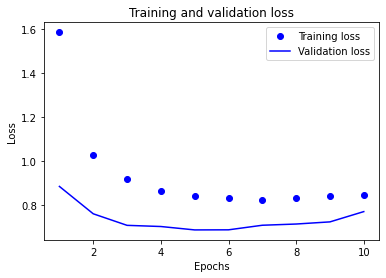

In [111]:
history_dict = history.history
epoch_val_loss = list(enumerate(history_dict['val_loss']))
epoch_val_acc = history_dict['val_accuracy']
tup = min(epoch_val_loss, key=lambda x: x[1])
print("epoch = {}, acc = {}, loss = {}".format(tup[0], epoch_val_acc[tup[0]], tup[1]))

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
epoch_val_acc = list(enumerate(history_dict['val_accuracy']))
tup = max(epoch_val_acc, key=lambda x: x[1])

loss = epoch_val_loss[tup[0]][1]
print("epoch = {}, acc = {}, loss = {}".format(tup[0], tup[1], loss))

plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:

pos, form, booli = generate_feature_list(size_feature_groups)
sentence = formatted_corpus_test_clean[0]
stack, queue, graph = init_config(sentence)
pos, form, deprel, bool_one_hot = extract(depth, stack, queue, graph, sentence, pos, form, booli)

pos, form, deprel, bool_one_hot = flatten_lists([pos, form, deprel, bool_one_hot])

pos = list(map(lambda pos_indexes_row: np.array(pos_indexes_row), X_pos)) 
form = list(map(lambda form_indexes_row: np.array(form_indexes_row), X_form))  
deprel = list(map(lambda deprel_indexes_row: np.array(deprel_indexes_row), X_deprel))  
bool_one_hot = one_hot_set_all(X_bool)
    
features = [pos, form, deprel, bool_one_hot]

tags = ['pos', 'form', 'bool']
x = zip_iterating_lists_dic(features, tags)

for k, v in x.items():
    if k[0:4] == 'form':
        x[k] = x[k].reshape(-1, 1)
    elif k[0:3] == 'pos':
        x[k] = x[k].reshape(-1, 1, pos_column_length)
    elif k[0:4] == 'bool':
        x[k] = x[k].reshape(-1, 1, 2)

#print(x)
#print(X_train['form0'], X_train['form1'])
prob_matrix = model.predict(x)[0]
dict(zip(classes, prob_matrix))


Fit the model. With sklearn, you can use `y_symbols` directly. Use `verbose=True` and `n_jobs=8` or more.

## Prediction

Now use this model to predict the sentences in the test corpus

In [ ]:
def reset():
    sentences_test = read_sentences(path_sv_test)
    formatted_corpus_test = split_rows(sentences_test, column_names_u)
    formatted_corpus_test_clean = clean_indicies(formatted_corpus_test)
    clean_test = copy.deepcopy(formatted_corpus_test_clean)
    
    return formatted_corpus_test_clean, formatted_corpus_test, clean_test

In [ ]:
def apply_transition(stack, queue, graph, trans):
    if stack and trans[:2] == 'ra':
        if trans[3:] == 'root' and exists_root(graph):
            stack, queue, graph = shift(stack, queue, graph)
            return stack, queue, graph, 'sh'
        else:
            stack, queue, graph = right_arc(stack, queue, graph, trans[3:])
            return stack, queue, graph, 'ra'
    if stack and can_leftarc(stack, graph) and trans[:2] == 'la':
        if trans[3:] == 'root' and exists_root(graph):
            stack, queue, graph = shift(stack, queue, graph)
            return stack, queue, graph, 'sh'
        else:
            stack, queue, graph = left_arc(stack, queue, graph, trans[3:])
            return stack, queue, graph, 'la'
    if stack and can_reduce(stack, graph) and trans == 're':
        stack, queue, graph = reduce(stack, queue, graph)
        return stack, queue, graph, 're'
    stack, queue, graph = shift(stack, queue, graph)
    
    return stack, queue, graph, 'sh'

In [ ]:
def apply_trans_deep(stem, action):
    stack, queue, graph = stem['params'][0:3]
    stack_c, queue_c, graph_c = copy.deepcopy(stack), copy.deepcopy(queue), copy.deepcopy(graph)
    
    return apply_transition(stack_c, queue_c, graph_c, action)

In [ ]:
def dictorize_prob_matrix(prob_matrix):
    return dict(zip(classes, prob_matrix))

def class_to_top_proba(prob_matrix_dict, depth, tool=1):
    sorted_prob = list(sorted(prob_matrix_dict.items(), key=lambda entry: -entry[1]))
    max_val = sorted_prob[0][1]
    
    filtred_prob = list(filter(lambda prob_tupel: prob_tupel[1] > max_val - tool, sorted_prob))
    
    return filtred_prob[0:depth]
        

In [ ]:
def boolean_one_hot(value):
    one_hot = np.zeros((1, 2))
    
    if value:
        one_hot[0, 0] = 1
    else:
        one_hot[0, 1] = 1
    
    return one_hot[0]

In [ ]:
def flatten_lists(lists):
    for index, li in enumerate(lists):
        lists[index] = list(map(lambda list_item: list_item[0], li)) 
        
    return lists

In [ ]:
def predictions(x):   
            
    y_probabilites = model.predict(x)[0]
    return dictorize_prob_matrix(y_probabilites)

In [212]:
def calculate(beam, branches, tool):
    done = True
    
    nbrBranches = len(branches)
    for nbr in range(nbrBranches): 
                stem = branches[nbr]
                stack, queue, graph = stem['params'][0:3]
                
                features = extract_features_n_form(depth, stack, queue, graph, sentence, size_feature_groups)
                dictorized_proba = predictions(features)

                searchRange = beam - (nbrBranches - 1)
                top_proba = class_to_top_proba(dictorized_proba, searchRange, tool)

                if len(queue) > 0:
                    done = False

                    for action, prob_of_action in top_proba[1:]:
                        stack_n, queue_n, graph_n, trans = apply_trans_deep(stem, action)

                        sequence = stem['sequence'] + [trans]
                        total_prob = stem['score'] * prob_of_action
                        params = [stack_n, queue_n, graph_n, trans]

                        branch = {'params' : params, 'score' : total_prob, 'sequence' : sequence}                   
                        branches[nbrBranches] = branch

                        nbrBranches += 1;

                    action, prob_of_action = top_proba[0]

                    stack, queue, graph, trans = apply_transition(stack, queue, graph, action)

                    stem['sequence'].append(trans)
                    stem['score'] *= prob_of_action
                    stem['params'] = [stack, queue, graph, trans]
        
    return done, nbrBranches == beam

In [ ]:
def assign_values_to(sentence, graph):
    for word in sentence:     
        word['HEAD'] = graph['heads'][word['ID']]
        word['DEPREL'] = graph['deprels'][word['ID']]

In [ ]:
from tqdm import tqdm
formatted_corpus_test_clean, formatted_corpus_test, clean_test = reset()

beam = 1

tool = 1
graphs = []

for sent_cnt, sentence in tqdm(enumerate(formatted_corpus_test_clean)):
    X_test_dict = []
    
    stack, queue, graph = init_config(sentence)
    branches = {0 : {'params' : [stack, queue, graph], 'score' : 1, 'sequence' : []}}
    done = False
    
    while not done:
        done, trash = calculate(beam, branches, tool)
                    
    branch = max(branches.values(), key=lambda branch: branch['score'])
    params = branch['params']
    
    stack, graph = params[0], params[2] 
    stack, graph = empty_stack(stack, graph)
    graphs.append(graph)
    
    assign_values_to(sentence, graph)

In [175]:
from tqdm import tqdm
formatted_corpus_test_clean, formatted_corpus_test, clean_test = reset()

beam = 10
reach = 5
tool = 0.75
graphs = []

for sent_cnt, sentence in tqdm(enumerate(formatted_corpus_test_clean)):
    X_test_dict = []
    
    stack, queue, graph = init_config(sentence)
    branches = {0 : {'params' : [stack, queue, graph], 'score' : 1, 'sequence' : [], 'location' : 0}}
    
    done = False
    full = False
    
    while not done:
        if full:
            done = True
            
            results = []
            indexs = []
            
            for nbr in range(beam):
                stem = branches[nbr]
                stack, queue, graph = stem['params'][0:3]
                if len(queue) > 0:
                    indexs.append(nbr)
                    done = False
                    dictorized_proba = probabilites(depth, stack, queue, graph, sentence)

                    top_proba = class_to_top_proba(dictorized_proba, 1 + reach)
                    results += list(map(lambda tupel: [nbr, stem['score']*tupel[1], tupel[0]], top_proba))
            
            if not done:
                old_branches = copy.copy(branches)
                sorted_results = sorted(results, key=lambda idx_tupel: -idx_tupel[1])
                
                new_branches = len(indexs)
                for nbr in range(new_branches):
                    info = sorted_results[nbr]

                    branch_id = info[0]
                    score = info[1]
                    action = info[2]

                    stem = old_branches[branch_id]
                    stack, queue, graph, trans = apply_trans_deep(stem, action)

                    sequence = stem['sequence'] + [trans]
                    params = [stack, queue, graph, trans]

                    branch = {'params' : params, 'score' : score, 'sequence' : sequence}  

                    branches[indexs[nbr]] = branch
 
        else:
            done, full = calculate(beam, branches, tool)
    
    branch = max(branches.values(), key=lambda branch: branch['score'])            
    params = branch['params']
    
    stack, graph = params[0], params[2] 
    stack, graph = empty_stack(stack, graph)
    graphs.append(graph)
    
    assign_values_to(sentence, graph)

1219it [16:05:53, 47.54s/it]   


In [ ]:
graph_collection_errors(clean_test, graphs, cond_deprel=True)

In [44]:
formatted_corpus_test_clean[8]

NameError: name 'formatted_corpus_test_clean' is not defined

In [ ]:
formatted_corpus_test[0]

In [ ]:
len(formatted_corpus_test_clean)

In [ ]:
def save(file, formatted_corpus, column_names):
    f_out = open(file, 'w', encoding='utf-8')
    for sentence in formatted_corpus:
        for row in sentence[1:]:
            # print(row, flush=True)
            for col in column_names[:-1]:
                if col in row:
                    f_out.write(row[col] + '\t')
                else:
                    f_out.write('_\t')
            col = column_names[-1]
            if col in row:
                f_out.write(row[col] + '\n')
            else:
                f_out.write('_\n')
        f_out.write('\n')
    #f_out.write('\n')
    f_out.close()

In [ ]:
out_file_name = 'out_sys'
save(out_file_name, formatted_corpus_test_clean, column_names_u)

### Evaluation

1. Once you have parsed the test set, you will measure the accuracy of your parser using the CoNLL evaluation script available here: http://universaldependencies.org/conll18/evaluation.html. Download it.
2. You will run the evaluation in the cell below. Be sure to have the Python program in your folder.
2. You will report your best score. You need to reach a _labelled attachment score_ (LAS) of 0.67 to pass this lab.

In [ ]:
import conll18_ud_eval
system_ud_file = open(out_file_name, encoding='utf-8')
system_ud = conll18_ud_eval.load_conllu(system_ud_file)

gold_ud_file = open(path_sv_test, encoding='utf-8')
gold_ud = conll18_ud_eval.load_conllu(gold_ud_file)

las = conll18_ud_eval.evaluate(gold_ud, system_ud)['LAS']
las.precision
las.recall
las.f1

Should you want to run the script in other experiments, just execute: `python conll18_ud_eval.py gold_file system_file`

### Reading

Read the article: _Globally Normalized Transition-Based Neural Networks_ by Andor and al. (2016) [<a href="https://www.aclweb.org/anthology/P16-1231">pdf</a>] and write in a few sentences how it relates to your work in this assignment.</p>

## Submission

When you have written all the code and run all the cells, fill in your ID and as well as the name of the notebook.

In [ ]:
STIL_ID = ["vi1146ol-s"] # Write your stil ids as a list
CURRENT_NOTEBOOK_PATH = os.path.join(os.getcwd(), 
                                     "c-dependency_parsing.ipynb") # Write the name of your notebook

The submission code will send your answer. It consists of your best labeled attachment score.

In [ ]:
import json
ANSWER = json.dumps({'las': las
                    })
ANSWER

Now the moment of truth:
1. Save your notebook and
2. Run the cells below

In [ ]:
SUBMISSION_NOTEBOOK_PATH = CURRENT_NOTEBOOK_PATH + ".submission.bz2"

In [ ]:
import bz2
ASSIGNMENT = 6
API_KEY = "f581ba347babfea0b8f2c74a3a6776a7"

# Copy and compress current notebook
with bz2.open(SUBMISSION_NOTEBOOK_PATH, mode="wb") as fout:
    with open(CURRENT_NOTEBOOK_PATH, "rb") as fin:
        fout.write(fin.read())

In [ ]:
import requests
res = requests.post("https://vilde.cs.lth.se/edan20checker/submit", 
                    files={"notebook_file": open(SUBMISSION_NOTEBOOK_PATH, "rb")}, 
                    data={
                        "stil_id": STIL_ID,
                        "assignment": ASSIGNMENT,
                        "answer": ANSWER,
                        "api_key": API_KEY,
                    },
               verify=True)

# from IPython.display import display, JSON
res.json()